In [20]:
pip install langchain-groq

Note: you may need to restart the kernel to use updated packages.


In [21]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langchain_community.llms import Ollama
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from youtube_transcript_api import YouTubeTranscriptApi
import re
from IPython.display import Image, display
import requests
import json
import os
from dotenv import load_dotenv
from urllib.parse import urlparse, parse_qs
# working to get the transcript of the youtube video
# Python data structure

In [22]:
load_dotenv()


True

In [23]:
openai_api_key = os.getenv("OPENAI_API_KEY")

In [24]:
openai_groq_key = os.getenv("GROQ_API_KEY")

In [25]:
llm = ChatGroq(
    model="llama3-8b-8192",  # or "gpt-3.5-turbo" for a less expensive option
    temperature=0,
    api_key=openai_groq_key
)

In [26]:
# llm = ChatOpenAI(
#     model="gpt-4o-mini",  # or "gpt-3.5-turbo" for a less expensive option
#     temperature=0,
#     api_key=openai_api_key
# )



In [27]:
from typing import Optional


class YoutubeBlogState(TypedDict):
    video_url: str
    transcript: Annotated[str, "add_transcript"]
    summary: Annotated[str, "generate_summary"]
    blog_post: Annotated[str, "generate_blog_post"]
    human_review: Annotated[Optional[str], "add_human_review"]  # Add this line



# This function extracts the transcript from the YouTube video tools

In [28]:
def extract_transcript(state: YoutubeBlogState) -> YoutubeBlogState:
    video_url = state['video_url']
    try :
        # Extract Video ID from URL
        video_id = video_url.split('v=')[-1].split('&')[0]
        # Fetch transcript from YouTube
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        # Convert transcript to text
        transcript_text = ' '.join([t['text'] for t in transcript])
        # Update state with transcript
        state['transcript'] = transcript_text
        return state
    except Exception as e:
        return f"Error: {str(e)}"


# AI agent to summarize the transcript
# Prompting the AI to summarize the transcript

In [29]:
def summarize_transcript(state: YoutubeBlogState) -> YoutubeBlogState:
    transcript = state['transcript']
    if not transcript:
        return "No transcript available"   # if no transcript is available, return an error message
    # Initialize OpenAI API client
    prompt = f"""
    Summarize the following YouTube transcript while maintaining key insights:
    {transcript}
    """
    # Generate summary using OpenAI API
    summary = llm.invoke(prompt)
    # Update state with summary
    state['summary'] = summary
    return state

# AI agent to generate a blog post from the summary


In [30]:
def generate_blog_post(state: YoutubeBlogState) -> YoutubeBlogState:
    summary = state['summary']
    if not summary:
        return "No summary available"   # if no summary is available, return an error message
    # Initialize OpenAI API client
    prompt = f"""
    Convert the following summarized transcript into a well-structured blog post:
    {summary}
    The blog should be engaging, informative, and well-structured with an introduction, key takeaways, and a conclusion. 
    Also if any code is explained, include in the final blog the code snippet and explain briefly the code as well.
    """
    blog_post = llm.invoke(prompt)
    # Update state with blog post
    state['blog_post'] = blog_post
    return state




# AI for human review 


In [31]:
def human_review(state: YoutubeBlogState) -> YoutubeBlogState:
    blog_post = state['blog_post']
    if not blog_post:
        return "No blog post available"   # if no blog post is available, return an error message
    # Initialize OpenAI API client
    print("Please review the following blog post:") 
    decision = input("\nApprove blog? (yes/no): ").strip().lower()
    if decision == 'yes':
        state["review_approved"] = True
        state["human_review"] = "" # No feedback needed
    else:
        state["review_approved"] = False
        state["human_review"] =  input("\nProvide feedback for improvement: ")
    return state




# AI agent to revise the blog post

In [32]:
def revise_blog(state: YoutubeBlogState) -> YoutubeBlogState:
    blog_post = state['blog_post']
    feedback = state['human_review']
    prompt = f"""
    Revise the following blog post based on the feedback provided:
    {blog_post}
     The reviewer has given the following feedback:
    {feedback}
    """
    revised_blog = llm.invoke(prompt)
    state['blog_post'] = revised_blog
    return state


In [33]:
from langgraph.graph import END, START, StateGraph

def should_continue(state: YoutubeBlogState) -> YoutubeBlogState:
    """ Return the next node to execute """

    # Check if approved
    if state["review_approved"]:
        return END
    
    # Otherwise 
    return "revise_blog"



In [34]:
workflow = StateGraph(YoutubeBlogState)


In [35]:
# Define the workflow
workflow.add_node("extract_transcript", extract_transcript)
workflow.add_node("summarize_transcript", summarize_transcript)
workflow.add_node("generate_blog_post", generate_blog_post)
workflow.add_node("human_review_node", human_review)
workflow.add_node("revise_blog", revise_blog)

# Define the edges
workflow.add_edge(START, "extract_transcript")
workflow.add_edge("extract_transcript", "summarize_transcript")
workflow.add_edge("summarize_transcript", "generate_blog_post")
workflow.add_edge("generate_blog_post", "human_review_node")
workflow.add_conditional_edges("human_review_node", should_continue,["revise_blog",END])
workflow.add_edge("revise_blog", "human_review_node")

# Run the workflow
# workflow.compile()
# workflow.invoke({"video_url": "https://www.youtube.com/watch?v=dQw4w9WgXcQ"})


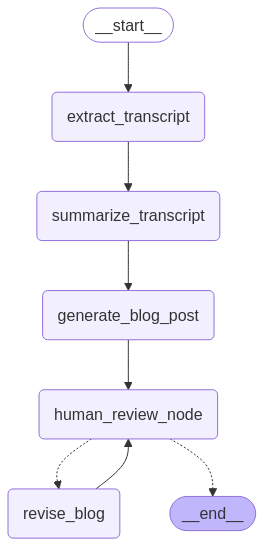

In [41]:
# Run the workflow
compiled_graph = workflow.compile()
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [37]:
# Make sure all required keys are in the initial state
initial_state = {
    "video_url": "https://www.youtube.com/watch?v=dQw4w9WgXcQ",
    "human_review": None  # Initialize with a default value
}

In [38]:
compiled_graph.invoke(initial_state)

Please review the following blog post:
Please review the following blog post:


{'video_url': 'https://www.youtube.com/watch?v=dQw4w9WgXcQ',
 'transcript': "[Music] we're no strangers to love you know the rules and so do I I full commitments while I'm thinking of you wouldn't get this from any other guy I just want to tell you how I'm feeling got to make you understand Never Going To Give You Up never going to let you down never going to run around and desert you never going to make you cry never going to say goodbye never going to tell a lie and hurt you we've known each other for so long your heart's been aching but your to sh to say it inside we both know what's been going on we know the game and we're going to playing and if you ask me how I'm feeling don't tell me you're too my you see Never Going To Give You Up never going to let you down never to run around and desert you never going to make you cry never going to say goodbye never going to tell a lie and hurt you never going to give you up never going to let you down never going to run around and desert yo

In [40]:
display(Image(workflow.get_graph().draw_mermaid_png()))

AttributeError: 'StateGraph' object has no attribute 'get_graph'

In [39]:
# workflow_image = workflow.to_graph().draw()
# display(Image(workflow_image))

AttributeError: 'StateGraph' object has no attribute 'to_graph'